In [153]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [154]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [155]:
plotly.offline.init_notebook_mode(connected=True)

In [156]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 

# Get celebA dataset

In [157]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [158]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [159]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [160]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [161]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

class MinMax(object):
    def __init__(self, mean0=True):
        self.mean0 = mean0
        pass
    def __call__(self, img):
        return torch.Tensor(min_max(cuda2numpy(img), mean0=self.mean0))
    def __repr__(self):
        return self.__class__.__name__

transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

In [162]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


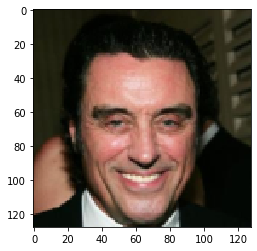

In [163]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

In [164]:
class SingleGAN_training():
    def __init__(self, net, opt, criterion, lbd, unrolled_k, evice, ref_label,
                 batch_size=64, encoded_feature="latent", styleINdataset=True):
        self.G, self.D, self.E = net[0].to(device), net[1].to(device), net[2].to(device)
        self.optG, self.optD, self.optE = opt[0], opt[1], opt[2]
        self.scheG, self.scheD, self.scheE = None, None, None
        self.criterion, self.criterion_class = criterion
        self.lbd = lbd
        self.k = unrolled_k
        self.device = device
        self.ref_label = ref_label
        self.n_batch = batch_size
        self.encoded_feature = encoded_feature
        self.styleINdataset = styleINdataset
        self.source_image = None
        self.target_image = None
        self.recon_image = None
        self.label = None
        self.c_rand = None
        self.enc_info = None
        self.target_cenc = None
    
    def opt_sche_initialization(self, lr=[0.0001, 0.0001, 0.0001]):
        lr_G, lr_D, lr_E = lr
        if self.optG==None:
            self.optG = optim.Adam(self.G.parameters(), lr=lr_G, betas=(0.5, 0.999))
        self.scheG = optim.lr_scheduler.ExponentialLR(self.optG, gamma=0.95)
        if self.optD==None:
            self.optD = optim.Adam(self.D.parameters(), lr=lr_D, betas=(0.5, 0.999))
        self.scheD = optim.lr_scheduler.ExponentialLR(self.optD, gamma=0.95)
        if self.optE==None:
            self.optE = optim.Adam(self.E.parameters(), lr=lr_E, betas=(0.5, 0.999))
        self.scheE = optim.lr_scheduler.ExponentialLR(self.optE, gamma=0.95)
        return
        
    def G_transformation(self, target_label, source_image, encoder=False, ref_image=None):
        if encoder:
            latent, mu, logvar, class_output, attention = self.E(ref_image)
            info = [latent, mu, logvar, class_output, attention]
            if self.encoded_feature == "latent":
                latent_vector = latent
            elif self.encoded_feature == "mu":
                latent_vector = mu
                
        else:
            latent_vector = torch.randn(source_image.shape[0], ndim).to(device)
            info = latent_vector
            
        class_vector = class_encode(target_label, self.device, self.ref_label)
        class_vector = torch.cat([class_vector, latent_vector], 1)
        target_image = self.G(source_image, class_vector)
        
        return target_image, info
        
    def update_D(self):
        self.D.zero_grad()
        if styleINdataset:
            c, random = self.label["index"]
            self.target_image, [_,self.c_rand,_,_,_] = self.G_transformation(self.label["target"], self.source_image, True, self.source_image[c][random])
        else:
            self.target_image, self.c_rand = self.G_transformation(self.label["target"], self.source_image, False)
        
        errD = 0
        # real image
        output, output_class = self.D(self.source_image)
        errD_real = get_loss_D(output, 1., criterion, device)
        errD_class = get_domainloss_D(output_class, class_encode(label["source"], self.device, self.ref_label), criterion_class)
        errD += errD_real + errD_class*self.lbd["class"]

        # fake image
        output, output_class = self.D(self.target_image.detach())
        errD_fake = get_loss_D(output, 0., criterion, device)
        errD += errD_fake

        # gradient penalty
        if self.lbd["gp"] > 0:
            errD_gp = get_gradient_penalty(self.D, self.source_image, self.target_image.detach())
            errD += errD_gp * self.lbd["gp"]
            
        errD.backward()
        self.optD.step()
        return errD
    
    def update_GandE(self):
        self.G.zero_grad()
        self.E.zero_grad()

        errG = 0
        errE = 0
        errE_output = 0

        ## ordinary SingleGAN loss
        recon_image, source_enc_info = self.G_transformation(self.label["source"], self.target_image, True, self.source_image)
        output, output_class = self.D(self.target_image)
        errG_dis = get_loss_D(output, 1., criterion, device)
        errG_class = get_domainloss_D(output_class, class_encode(self.label["target"], self.device, self.ref_label), criterion_class)
        errG_cycle = torch.mean(torch.abs(self.source_image - recon_image))
        errG += errG_dis + errG_class*self.lbd["class"] + errG_cycle*self.lbd["cycle"]
        errE_output += errG_cycle * self.lbd["cycle"]
        
        ## multimodal transformation (KL): Conventional KL
        if self.lbd["KL"] > 0:
            _, mu, logvar, _, _ = source_enc_info
            errE_KL = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp_()) 
            errE += errE_KL*self.lbd["KL"]
            errE_output += errE_KL*self.lbd["KL"]
            
        ## Identity loss under source style condition
        if self.lbd["idt"] > 0:
            identity_image, _ = self.G_transformation(self.label["source"], self.source_image, True, self.source_image)
            errG_idt = torch.mean(torch.abs(self.source_image - identity_image))
            errG += errG_idt*self.lbd["idt"]
            errE_output += errG_idt*self.lbd["idt"]
            
        ## encoder attention loss
        if self.lbd["attention"] > 0:
            _, _, _, _, attention = source_enc_info
            errE_att = get_focus_loss(attention, lbd=1)
            errE += errE_att*self.lbd["attention"]
            errE_output += errE_att*self.lbd["attention"]
        
        ## encoder classification loss
        if self.lbd["class_enc"] > 0:
            _, _, _, output_class_enc, _ = source_enc_info
            errE_class_enc = get_domainloss_D([output_class_enc], class_encode(self.label["source"], self.device, self.ref_label), criterion_class)
            errE += errE_class_enc*self.lbd["class_enc"]
            errE_output += errE_class_enc*self.lbd["class_enc"]
            
        ## batch size KL
        if self.lbd["batch_KL"] > 0:
            _, mu, _, _, _ = source_enc_info
            var = torch.var(mu, dim=0)*self.n_batch/(self.n_batch-1)
            mean = torch.mean(mu, dim=0)
            errE_bKL = -0.5 * torch.sum(1 + torch.log(var) - mean**2 - var) 
            errE += errE_bKL*self.lbd["batch_KL"]
            errE_output += errE_bKL*self.lbd["batch_KL"]
            
        ## correlative loss
            if self.lbd["corr_enc"] > 0:
                errE_corr = corrcoef_loss(mu.T, self.device)
                errE += errE_corr*self.lbd["corr_enc"]
                errE_output += errE_corr*self.lbd["corr_enc"]
                
        ## histgram imitation loss
            if self.lbd["hist"] > 0:
                errE_hist = hi.loss(mu)
                errE += errE_hist*self.lbd["hist"]
                errE_output += errE_hist*self.lbd["hist"]
                
        ## Consistency Regularization
        if self.lbd["consis_reg"] > 0:
            augmented = get_augmented_image(self.source_image, augment)
            _, augmented_mu, _, _, _ = self.E(augmented)
            _, source_mu, _, _, _ = source_enc_info
            
            errE_consis_reg = torch.mean(torch.abs(augmented_mu - source_mu)*2)
            errE += errE_consis_reg*self.lbd["consis_reg"]
            errE_output += errE_consis_reg*self.lbd["consis_reg"]
        
        errG.backward(retain_graph=True)
        errE.backward(retain_graph=True)
        self.optG.step()
        self.optE.step()
        
        ########################### update exclusively G ###########################
        self.G.zero_grad()
        self.E.zero_grad()
        
        errG_ex = 0
        ## multimodal transformation (regression loss)
        _, target_cenc, _, _, _ = self.E(self.target_image)
        errG_reg = torch.mean(torch.abs(self.c_rand - target_cenc))
        errG_ex += errG_reg * self.lbd["reg"]
        
        ## multimodal transformation (regression loss for identity images)
        if self.lbd["idt_reg"]*self.lbd["idt"] > 0:
            errG_idt_reg = 0
            
            ## random condition
            if styleINdataset:
                idt_random_image, [_,source_c_rand,_,_,_] = self.G_transformation(self.label["source"], self.source_image, True, self.source_image)
            else:
                idt_random_image, source_c_rand = self.G_transformation(self.label["source"], self.source_image, False)
            _, idt_cenc_rand, _, _, _ = self.E(idt_random_image)
            errG_idt_reg += torch.mean(torch.abs(source_c_rand - idt_cenc_rand))
            errG_ex += errG_idt_reg * self.lbd["idt_reg"] * (self.lbd["idt"]/self.lbd["cycle"])
            
        errG_ex.backward()
        self.optG.step()
        
        errG += errG_ex
        
        return [errG, errE_output]
    
    def UnrolledUpdate(self):
        for i in range(self.k):

            # update D
            errD = self.update_D()
            if i==0:
                paramD = self.D.state_dict()
                errorD = errD

        # update G
        errorG, errorE = self.update_GandE()

        self.D.load_state_dict(paramD)
        return [errorG, errorD, errorE]
        
    def train(self, source_image, label):
        self.source_image = source_image
        self.label = label
        error = self.UnrolledUpdate()
        return error

# conditional GAN

In [165]:
epoch_num = 31
lr_D = 0.0001
lr_G = 0.0002
lr_E = 0.001
# torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [174]:
# ---- adjustable parameters ---- #
ndim = 8 # the dimension of noise vector, indicating the style
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4

model_type = "nopretraining" # "nopretraining", "gradattention", "pretrained"
attention_mode = "relu" # this will be available when you set 'model_type' as "gradattention": "relu", "relumodified"
restriction_type = "proposedKL" # "conventionalKL", "proposedKL"
styleINdataset = False
save_parameter = True
###################################

ref_label = np.eye(len(classes))
if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"
if styleINdataset:
    styleINdataset_or_not = "styleINdataset_"
else:
    styleINdataset_or_not = ""
hi = histogram_imitation(device)

In [175]:
devices = [0,1,2,3]
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
netD.apply(weights_init)
netD = nn.DataParallel(netD, devices)
if model_type in ["nopretraining", "pretrained"]:
    netE = Encoder(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
elif model_type=="gradattention":
    netE = Encoder_gradattention(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], attention_mode).to(device)
netE.apply(weights_init);

In [176]:
if model_type in ["gradattention", "pretrained"]:
    model_path = f"./model_parameters/Mpaper/72/facial_recognizer_lr0.0001_epoch51.pth"
    netE = load_classifier(netE, model_path)
    classifier = Encoder_classifier(nch_in, ndim, nch, 4, norm_type, ref_label.shape[1]).to(device)
    classifier_layers = list(classifier.state_dict().keys())
    netE.freeze_melt(classifier_layers, "freeze")
    optE = optim.Adam(filter(lambda p: p.requires_grad, netE.parameters()), lr=0.001, betas=(0.5, 0.999))
    netE.freeze_melt(classifier_layers, "melt");
else:
    optE = None
netE = nn.DataParallel(netE, devices)

In [177]:
criterion = nn.MSELoss()
criterion_class = nn.MSELoss()

## train

In [178]:
lbd = {}
lbd["class"] = 1
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["reg"] = 0.5
lbd["idt_reg"] = 0.5
lbd["gp"] = 0
lbd["consis_reg"] = 0

if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100
    
if (model_type=="gradattention") and (attention_mode=="relumodified"):
    lbd["class_enc"] = 10
    lbd["attention"] = 1000
else:
    lbd["class_enc"] = 0
    lbd["attention"] = 0

unrolled_k = 5

In [179]:
each_train_num = 10000
batch_size = 128
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=16)
len(dataset), len(sampleset)

(40000, 64)

In [180]:
sg = SRGAN_training([netG, netD, netE], [None, None, optE], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, batch_size, encoded_feature, styleINdataset, ndim)
sg.opt_sche_initialization()

In [21]:
run_train = False
if run_train:
    interval = int(len(dataset)/batch_size/3) + 2
    losses_D = []
    losses_G = []
    losses_E = []
    for epoch in range(epoch_num):
        start_time = time.time()
        loss_D = []
        loss_G = []
        loss_E = []
        for itr, data in enumerate(dataloader):
            netG.train()
            data_image = data[0]
            data_label = data[1]

            source_image = data_image.to(device)
            label = {}

            label["source"] = data_label.to(device)
            whole_target = get_target(data_label, classes, whole=False)

            if styleINdataset:
                a = np.argsort(np.array(data_label))
                a_ = np.array(data_label)[a]
                b = list(a_)
                num = np.random.randint(1, 4)
                c = list(a)[b.index(num):] + list(a)[:b.index(num)]
                d = np.argsort(np.array(data_label))
                random = np.argsort(d)
                label["index"] = c, random
                label["target"] = data_label[c][random]
            else:
                label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")

            errG, errD, errE = sg.train(source_image, label)

            if type(errD)!=int:
                errD = errD.detach().to("cpu").numpy()
                loss_D.append(errD)
            if type(errG)!=int:
                errG = errG.detach().to("cpu").numpy()
                loss_G.append(errG)
            if type(errE)!=int:
                errE = errE.detach().to("cpu").numpy()
                loss_E.append(errE)

            if itr%interval==0:
                if not itr==0:
                    clear_output(wait=True)
                    print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                    fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, styleINdataset, device)

                    if not epoch==0:
                        length = 5
                        width = 4
                        losses = [losses_D, losses_G, losses_E]
                        ax = fig.add_subplot(length, width, 17)
                        models = ["Discriminator", "Generator", "Encoder"]
                        for k in range(len(losses)):
                            if models[k] == "Discriminator":
                                if type(losses[k]) == dict:
                                    for i in classes:
                                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                                elif type(losses[k]) == list:
                                    ax.plot(losses[k], label=f"Discriminator")
                            else:
                                ax.plot(losses[k], label=models[k])
                        ax.legend()
                    plt.show()

        if save_parameter:
            if epoch % 3 == 0:

                dir = "./instant_model_parameter/"
                if model_type == "nopretraining":
                    gen_path = dir + f"gen_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{epoch}"
                    dis_path = dir + f"dis_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{epoch}"
                    enc_path = dir + f"enc_modified_SingleGAN_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_unrolledk{unrolled_k}_epoch{epoch}"

                elif model_type == "pretrained":
                    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    dis_path = dir + f"dis_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"

                elif model_type == "gradattention":
                    gen_path = dir + f"gen_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    dis_path = dir + f"dis_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"
                    enc_path = dir + f"enc_Style-RestrictedGAN_type-{model_type}-{attention_mode}_{styleINdataset_or_not}idt{lbd['idt']}_cycle{lbd['cycle']}_gp{lbd['gp']}_KL{lbd['KL']}_reg{lbd['reg']}_classenc{lbd['class_enc']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_attention{lbd['attention']}_consisreg{lbd['consis_reg']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch{epoch}"

                torch.save(sg.G.module.state_dict(), gen_path)
                torch.save(sg.D.module.state_dict(), dis_path)
                torch.save(sg.E.module.state_dict(), enc_path)


        sg.scheD.step()
        losses_D.append(np.mean(loss_D))
        sg.scheG.step()
        losses_G.append(np.mean(loss_G))
        sg.scheE.step()
        losses_E.append(np.mean(loss_E))

        clear_output(wait=True)
        print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
        fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, styleINdataset, device)

        length = 5
        width = 4
        losses = [losses_D, losses_G, losses_E]
        ax = fig.add_subplot(length, width, 17)
        models = ["Discriminator", "Generator", "Encoder"]
        for k in range(len(losses)):
            if models[k] == "Discriminator":
                if type(losses[k]) == dict:
                    for i in classes:
                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                elif type(losses[k]) == list:
                    ax.plot(losses[k], label=f"Discriminator")
            else:
                ax.plot(losses[k], label=models[k])
        ax.legend()

        plt.show()